## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from functools import partial
import warnings
warnings.filterwarnings('ignore')
sns.set()

## Image Directory

In [2]:
os.listdir('../input/plant-village/PlantVillage/')

['Pepper__bell___Bacterial_spot',
 'Potato___healthy',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Early_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___healthy',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Potato___Early_blight',
 'Tomato__Tomato_mosaic_virus']

## Reading the Images

In [3]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Potato___Early_blight , 1 for Potato___Late_blight, 2 for Potato___healthy
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'Potato___Early_blight': #Folder contain Potato___Early_blight images get the '0' class label.
            label = 0
        elif labels == 'Potato___Late_blight':
            label = 1
        elif labels == 'Potato___healthy':
            label = 2
        else:
            continue
        print(labels)
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=42) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'Early blight', 1:'Late blight', 2:'Healthy'}
    
    return labels[class_code]

In [4]:
images, labels = get_images('../input/plant-village/PlantVillage/') #Extract the images from the folders.

images = np.array(images) #converting the list of images to numpy array.
labels = np.array(labels)

Potato___healthy
Potato___Late_blight
Potato___Early_blight


In [5]:
print(images.shape)
print(labels.shape)

(2152, 150, 150, 3)
(2152,)


## Functions to display images

In [6]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## Correspondance between images and labels

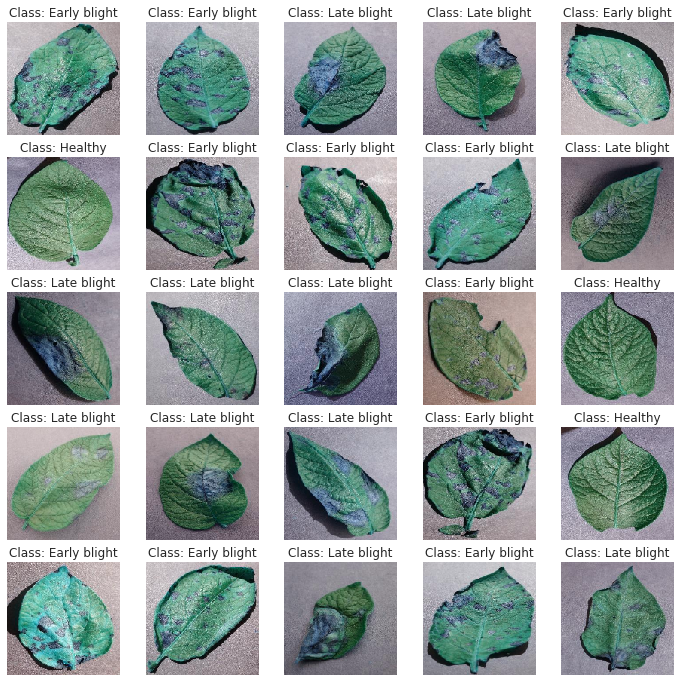

In [7]:
plt.figure(figsize=(12, 12))
for index in range(25):
    rnd = np.random.randint(0,len(images))
    plt.subplot(5, 5, index + 1)
    plot_color_image(images[index])
    plt.title("Class: {}".format(get_classlabel(labels[index])))
    plt.axis("off")
plt.show()

## Train, validation and test sets: 
* 10% test
* 20% validation
* 70% training

In [8]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels) # split images in train, test sets

In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train) # split train set in train and validation sets

In [10]:
print("Shape of X_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of X_valid :", x_valid.shape)
print("Shape of y_valid :", y_valid.shape)
print("Shape of X_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of X_train : (1548, 150, 150, 3)
Shape of y_train : (1548,)
Shape of X_valid : (388, 150, 150, 3)
Shape of y_valid : (388,)
Shape of X_test : (216, 150, 150, 3)
Shape of y_test : (216,)


## Setting the Seed to make the results consistent

In [11]:
tf.random.set_seed(42)
np.random.seed(42)

## Functions to preprocess images before using them in the model

In [12]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

## From numpy to tensors dataset format

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

2021-11-01 01:43:00.597253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 01:43:00.691127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 01:43:00.691834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 01:43:00.696313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

## Batch size for training and validate in batches

In [15]:
batch_size = 32
train_validation_size = x_train.shape[0] + x_valid.shape[0]
print(batch_size, train_validation_size)

32 1936


## Preprocessing the training images with the "preprocess" function

In [16]:
train_dataset = train_dataset.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)

In [17]:
valid_dataset = valid_dataset.map(preprocess).batch(batch_size).prefetch(1)

## Plotting training images

2021-11-01 01:43:05.567362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


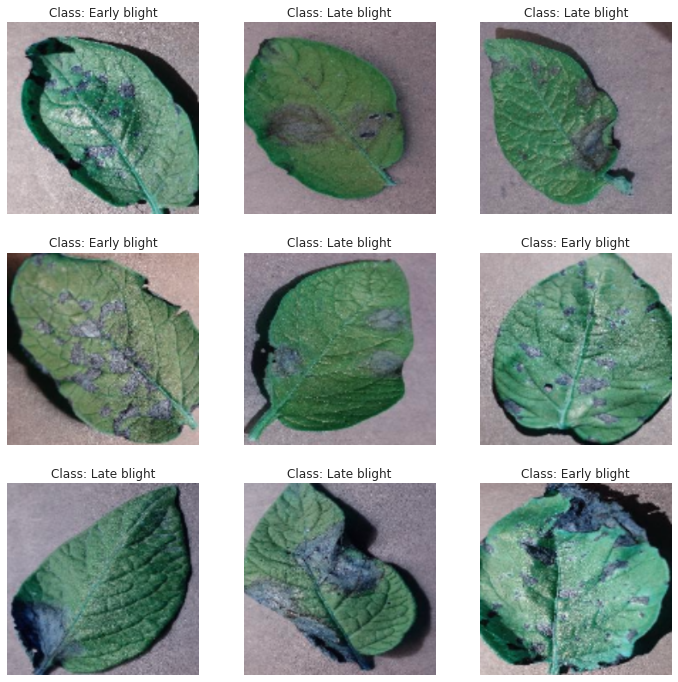

In [18]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_dataset.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(get_classlabel(y_batch[index].numpy())))
        plt.axis("off")

plt.show()

## Plotting validation images

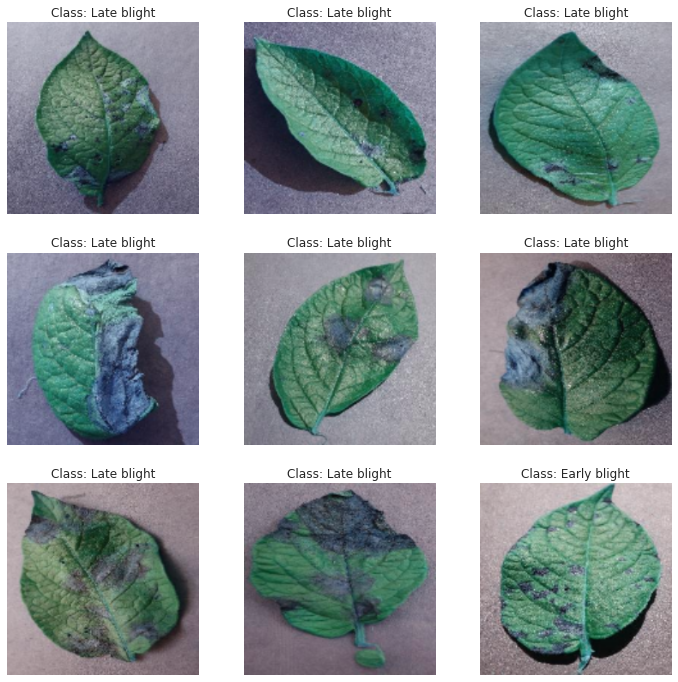

In [19]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_dataset.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(get_classlabel(y_batch[index].numpy())))
        plt.axis("off")

plt.show()

In [20]:
n_classes = 3 # 3 classes for Potato___Early_blight , 1 for Potato___Late_blight, 2 for Potato___healthy

## Loading Xception Model

In [21]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model_xception = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


## Training only the lasts layers

In [22]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_xception.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=5)

Epoch 1/5


2021-11-01 01:43:14.084172: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


49/49 [==============================] - 14s 123ms/step - loss: 2.4996 - accuracy: 0.7952 - val_loss: 1.9756 - val_accuracy: 0.8608
Epoch 2/5
49/49 [==============================] - 5s 92ms/step - loss: 0.4619 - accuracy: 0.9322 - val_loss: 0.7072 - val_accuracy: 0.8995
Epoch 3/5
49/49 [==============================] - 4s 91ms/step - loss: 0.2275 - accuracy: 0.9567 - val_loss: 0.2729 - val_accuracy: 0.9433
Epoch 4/5
49/49 [==============================] - 4s 92ms/step - loss: 0.1634 - accuracy: 0.9696 - val_loss: 0.4621 - val_accuracy: 0.9227
Epoch 5/5
49/49 [==============================] - 5s 92ms/step - loss: 0.0917 - accuracy: 0.9761 - val_loss: 0.4576 - val_accuracy: 0.9278


## Training the full model

In [23]:
for layer in base_model.layers:
    layer.trainable = True

checkpoint_cb = keras.callbacks.ModelCheckpoint("/kaggle/working/SavedModels/potatodisease/tmp/checkpoint",
                                                monitor='val_accuracy',
                                                mode='max', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_xception.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=40,
                    callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/40
49/49 [==============================] - 24s 406ms/step - loss: 0.1371 - accuracy: 0.9574 - val_loss: 0.5798 - val_accuracy: 0.8918


2021-11-01 01:44:25.126425: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/40
49/49 [==============================] - 19s 387ms/step - loss: 0.0051 - accuracy: 0.9981 - val_loss: 0.1471 - val_accuracy: 0.9742
Epoch 3/40
49/49 [==============================] - 19s 387ms/step - loss: 0.0054 - accuracy: 0.9981 - val_loss: 0.0968 - val_accuracy: 0.9716
Epoch 4/40
49/49 [==============================] - 19s 386ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1188 - val_accuracy: 0.9716
Epoch 5/40
49/49 [==============================] - 19s 387ms/step - loss: 9.2777e-05 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9742
Epoch 6/40
49/49 [==============================] - 19s 388ms/step - loss: 6.8528e-05 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9794
Epoch 7/40
49/49 [==============================] - 19s 387ms/step - loss: 5.5042e-05 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9845
Epoch 8/40
49/49 [==============================] - 19s 387ms/step - loss: 4.6470e-05 - accuracy: 1.0000 - val_loss: 0.0472 - val_

In [24]:
model_xception.save('/kaggle/working/h5/model_potato.h5')

## Plotting Training and Validation

In [25]:
def plot_training_vs_validation(history):
  fig, ax = plt.subplots(1,2,figsize=(10,5))
  ax[0].plot(history.history['accuracy'],'bd--', label = "train_acc")
  ax[0].plot(history.history['val_accuracy'],'rd--', label = "val_acc")
  ax[1].plot(history.history['loss'],'g*--', label = "train_loss")
  ax[1].plot(history.history['val_loss'],'c*--', label = "val_loss")
  ax[0].set_title('Training vs Validation [accuracy]')
  ax[1].set_title('Training vs Validation [loss]')
  ax[0].legend()
  ax[1].legend()
  ax[0].set_xlabel('Epochs')
  ax[1].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')
  ax[1].set_ylabel('Loss')
  plt.show()

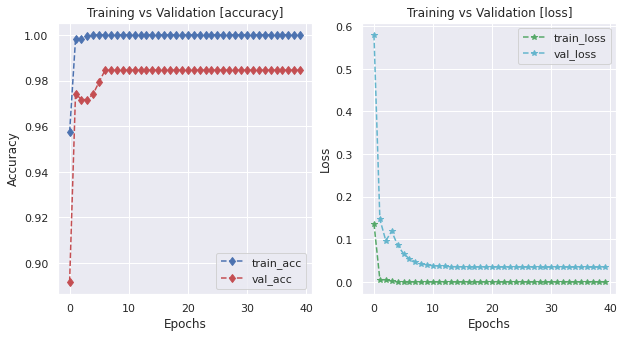

In [26]:
plot_training_vs_validation(history)

## Test set accuracy

In [27]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(batch_size)
len(test_dataset)
model_xception.evaluate(test_dataset)

7/7 [==============================] - 1s 113ms/step - loss: 0.0070 - accuracy: 1.0000


[0.006974626332521439, 1.0]

In [28]:
os.listdir('./h5')

['model_potato.h5']